In [1]:
# Import appropriate libraries
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns

In [2]:
# Read in csv data file
data = pd.read_csv("data.csv", low_memory=False)

In [3]:
# Display data variables and their types
data.dtypes

Id                   object
Title                object
Company              object
Date                 object
Location             object
Area                 object
Classification       object
SubClassification    object
Requirement          object
FullDescription      object
LowestSalary          int64
HighestSalary         int64
JobType              object
dtype: object

In [4]:
# Part 1: Data Preparation and Preprocessing
# Delete any rows where any variable is missing a variable(NaN)
data = data[data['Id'].notna()]
data = data[data['Title'].notna()]
data = data[data['Company'].notna()]
data = data[data['Date'].notna()]
data = data[data['Location'].notna()]
data = data[data['Area'].notna()]
data = data[data['Classification'].notna()]
data = data[data['SubClassification'].notna()]
data = data[data['Requirement'].notna()]
data = data[data['FullDescription'].notna()]
data = data[data['LowestSalary'].notna()]
data = data[data['HighestSalary'].notna()]
data = data[data['JobType'].notna()]


In [5]:
# Clean data by removing Id as it won't be used
del data["Id"]
# Format FullDescription removing html formats from the text
# Create function to remove the html tags from the descriptions
def del_html(string):
    import re
    # Clean FullDescription by removing all html tags, newline characters, and asterisks present in the strings
    filtered = re.compile('<.*?>|&nbsp;|&amp;|\u260e|\n|[*]', re.DOTALL|re.M)
    return re.sub(filtered, '', string)
data['FullDescription'] = data['FullDescription'].apply(del_html)
data.head()

,Title,Company,Date,Location,Area,Classification,SubClassification,Requirement,FullDescription,LowestSalary,HighestSalary,JobType
121,Fabricator/Installer,WORKPLACE ACCESS & SAFETY,2018-10-07T00:00:00.000Z,Melbourne,Bayside & South Eastern Suburbs,Trades & Services,Welders & Boilermakers,Trade qualified person with skills in welding ...,Secure long term role with genuine ca...,0,30,Full Time
122,Boilermaker,RPM Contracting QLD P/l,2018-10-07T00:00:00.000Z,Brisbane,Southern Suburbs & Logan,Trades & Services,Welders & Boilermakers,Perm rate $30. Structural steel fab & weld out...,One of Australia's best engineering workshops ...,0,30,Full Time
125,Casual Childcare Positions | Bondi Junction,anzuk Education,2018-10-07T00:00:00.000Z,Sydney,"CBD, Inner West & Eastern Suburbs",Education & Training,Teaching - Early Childhood,"anzuk education are searching for reliable, en...",What is anzuk? anzuk Early Childhoodis a rec...,0,30,Contract/Temp
126,Technician,Zoom Recruitment & Training,2018-10-07T00:00:00.000Z,Sydney,South West & M5 Corridor,Engineering,Mechanical Engineering,"This Australian Icon, connects the people of t...","This Australian Icon, connects the people of t...",0,30,Full Time
127,Systems Engineer,Humanised Group,2018-10-07T00:00:00.000Z,Brisbane,CBD & Inner Suburbs,Information & Communication Technology,Networks & Systems Administration,Systems Engineer to work on BAU/Projects for a...,The Company This organisation is well-establi...,0,30,Full Time


In [6]:
# Normalize the data by converting Date from object to Datetime data type
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Title                             object
Company                           object
Date                 datetime64[ns, UTC]
Location                          object
Area                              object
Classification                    object
SubClassification                 object
Requirement                       object
FullDescription                   object
LowestSalary                       int64
HighestSalary                      int64
JobType                           object
dtype: object

In [63]:
# Part 2: Data Analysis and Intepretation
# Question1: Job Metadata
# Find all job Classification and SubClassifications
# Extract the job title, classification, and subclassification
data1 = data[['Title','Classification','SubClassification']]
# Group the Classification and subclassification to measure classification and subclassification count
data1 = data1.groupby(['Classification','SubClassification']).size().reset_index().rename(columns={0:'Count'})

#The following line of code is to display each Sub Classification by popularity within their own Classifications
data1 = data1.sort_values(by=['Classification','Count'], ascending=False)

data1 = data1.reset_index()
print(data1.to_string())


     index                          Classification                                SubClassification  Count
0      372                       Trades & Services                                Automotive Trades   1601
1      378                       Trades & Services                                     Electricians    806
2      383                       Trades & Services                                        Labourers    691
3      379                       Trades & Services                    Fitters, Turners & Machinists    621
4      382                       Trades & Services                           Hair & Beauty Services    601
5      394                       Trades & Services                           Welders & Boilermakers    546
6      393                       Trades & Services                                      Technicians    526
7      376                       Trades & Services                       Carpentry & Cabinet Making    524
8      381                       Trad

In [62]:
# Determine most popular job Classification and SubClassifications
# Extract the job title, classification, and subclassification
data1 = data[['Title','Classification','SubClassification']]
# Group the Classification and subclassification to measure classification and subclassification count
data1 = data1.groupby(['Classification','SubClassification']).size().reset_index().rename(columns={0:'Count'})

#Sort classifications by the counts - this shows the most popular sub classifications
data1 = data1.sort_values(by=['Count'], ascending=False)

data1 = data1.reset_index()
print(data1.to_string())

     index                          Classification                                SubClassification  Count
0      234  Information & Communication Technology                           Developers/Programmers   2869
1       25         Administration & Office Support                        Administrative Assistants   2624
2      300    Manufacturing, Transport & Logistics              Warehousing, Storage & Distribution   2499
3      207                   Hospitality & Tourism                                      Chefs/Cooks   2429
4      347              Retail & Consumer Products                                Retail Assistants   2170
5      230  Information & Communication Technology                        Business/Systems Analysts   1878
6      354                                   Sales                Sales Representatives/Consultants   1838
7      166                    Government & Defence                               Government - State   1762
8      217                   Hospital

In [61]:
# Determine number of jobs in each location
data2 = data[['Title','Location','Area']]

# Two following two lines of code is to show the most popular locations were most of the jobs are located.
data2 = data2.groupby(['Location']).size().reset_index().rename(columns={0:'Count'})
data2 = data2.sort_values(by=['Count'], ascending=False)

data2 = data2.reset_index()

# Output may not be displayed to to large volume of data - top data sorted was used
#print(data2.to_string())

# Showcase of top of data to diplay part of the output
data2.head()


,index,Location,Count
0,3,Sydney,49174
1,1,Melbourne,37156
2,0,Brisbane,15658
3,2,Perth,9121


In [60]:
# Show all jobs, their locations, and areas
data2 = data[['Title','Location','Area']]

# The following two lines of code is to show the most popular areas in each location for each job
data2 = data2.groupby(['Title','Location','Area']).size().reset_index().rename(columns={0:'Count'})

# Show all jobs in each location and order them by count
data2 = data2.sort_values(by=['Location', 'Area','Count'], ascending=False)

data2 = data2.reset_index()

# Output may not be displayed to to large volume of data - top data sorted was used
#print(data2.to_string())

# Showcase of top of data to diplay part of the output
data2.head()

,index,Title,Location,Area,Count
0,63472,Senior Commercial Manager - Sales,Sydney,Southern Suburbs & Sutherland Shire,10
1,2652,Administration Assistant,Sydney,Southern Suburbs & Sutherland Shire,9
2,23700,Early Childhood Teacher,Sydney,Southern Suburbs & Sutherland Shire,7
3,30225,Full time Cook in Brighton-Le-Sands,Sydney,Southern Suburbs & Sutherland Shire,7
4,5347,Assistant Store Manager,Sydney,Southern Suburbs & Sutherland Shire,6


In [59]:
# Determine top Job locations
data2 = data[['Title','Location','Area']]

# The following two lines of code is to show the most popular areas in each location for each job
data2 = data2.groupby(['Title','Location','Area']).size().reset_index().rename(columns={0:'Count'})

# Show all jobs in each location and order them by count
#data2 = data2.sort_values(by=['Location', 'Area','Count'], ascending=False)

# Show top most popular jobs by count
data2 = data2.sort_values(by=['Count'], ascending=False)

data2 = data2.reset_index()

# Output may not be displayed to to large volume of data - top data sorted was used
#print(data2.to_string())

# Showcase of top of data to diplay part of the output
data2.head()

,index,Title,Location,Area,Count
0,53596,Project Manager,Sydney,"CBD, Inner West & Eastern Suburbs",137
1,53588,Project Manager,Melbourne,CBD & Inner Suburbs,115
2,8206,Business Analyst,Sydney,"CBD, Inner West & Eastern Suburbs",90
3,62953,Senior Business Analyst,Sydney,"CBD, Inner West & Eastern Suburbs",88
4,8723,Business Development Manager,Sydney,"CBD, Inner West & Eastern Suburbs",82


In [58]:
# Find range of salaries for each job
data3 = data[['Title','LowestSalary','HighestSalary']]
data3 = data3.groupby(['Title','LowestSalary','HighestSalary']).size().reset_index().rename(columns={0:'Count'})
# Sort both Lowest and Highest Salary - this shows the highest paying jobs
data3 = data3.sort_values(by=['LowestSalary', 'HighestSalary', 'Count'], ascending=False)
data3 = data3.reset_index()

# Output may not be displayed to to large volume of data - top data sorted was used
#print(data3.to_string())

# Showcase top of data instead of all the other data
data3.head()


,index,Title,LowestSalary,HighestSalary,Count
0,55696,Project Manager,200,999,73
1,68719,Senior Project Manager,200,999,51
2,65506,Senior Business Analyst,200,999,40
3,14311,Chief Financial Officer,200,999,30
4,32687,General Practitioner,200,999,30


In [52]:
# Question 2: Studying market by Locations
# Market size in each city - most common sectors in each city
data4 = data[['Classification','Location']]
data4 = data4.groupby(['Classification','Location']).size().reset_index().rename(columns={0:'Count'})
data4 = data4.sort_values(by=['Count'], ascending=False).drop_duplicates(['Location'])

data4 = data4.reset_index()

# Output may not be displayed to to large volume of data - top data sorted was used
data4.head()

# Showcase top of data instead of all the other data
#data4.head()


,index,Classification,Location,Count
0,71,Information & Communication Technology,Sydney,7501
1,69,Information & Communication Technology,Melbourne,4539
2,68,Information & Communication Technology,Brisbane,1900
3,118,Trades & Services,Perth,1020


         Location  LowestSalary  HighestSalary        JobType  AverageSalary
121     Melbourne             0             30      Full Time           15.0
122      Brisbane             0             30      Full Time           15.0
125        Sydney             0             30  Contract/Temp           15.0
126        Sydney             0             30      Full Time           15.0
127      Brisbane             0             30      Full Time           15.0
...           ...           ...            ...            ...            ...
197216     Sydney           200            999      Full Time          599.5
197217     Sydney           200            999  Contract/Temp          599.5
197218     Sydney           200            999  Contract/Temp          599.5
197222     Sydney           200            999      Full Time          599.5
197225  Melbourne           200            999      Full Time          599.5

[111109 rows x 5 columns]


<AxesSubplot:title={'center':'Average Salary for each JobType in each City'}, xlabel='Locations', ylabel='Salary(Average)'>

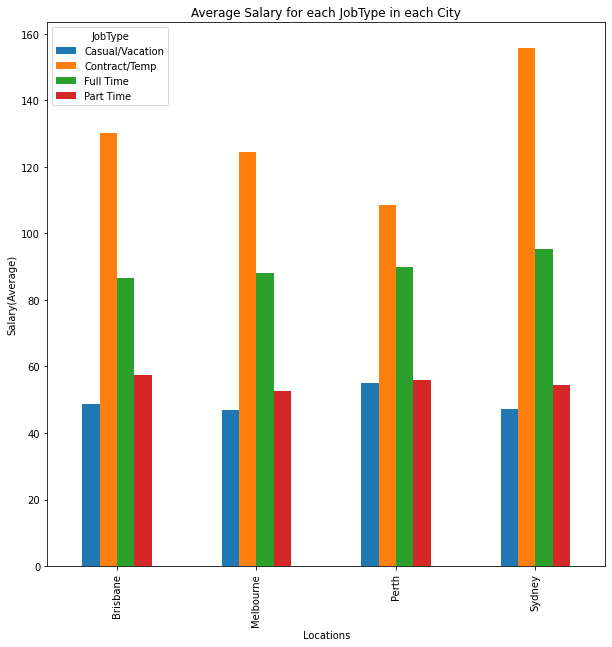

In [13]:
# Range of salary in each city based on job type
data5 = data[['Location','LowestSalary','HighestSalary','JobType']].copy()
data5['AverageSalary'] = (data5['LowestSalary'] + data5['HighestSalary']) / 2

print(data5)

data5.pivot_table(index='Location', columns='JobType', values='AverageSalary').plot(kind='bar',figsize=(10,10),ylabel='Salary(Average)',xlabel='Locations',title='Average Salary for each JobType in each City')


Date
October     67141
November    23402
December    20566
Name: Count, dtype: int64


<AxesSubplot:title={'center':'Job postings per date'}, xlabel='Date', ylabel='Number of job postings'>

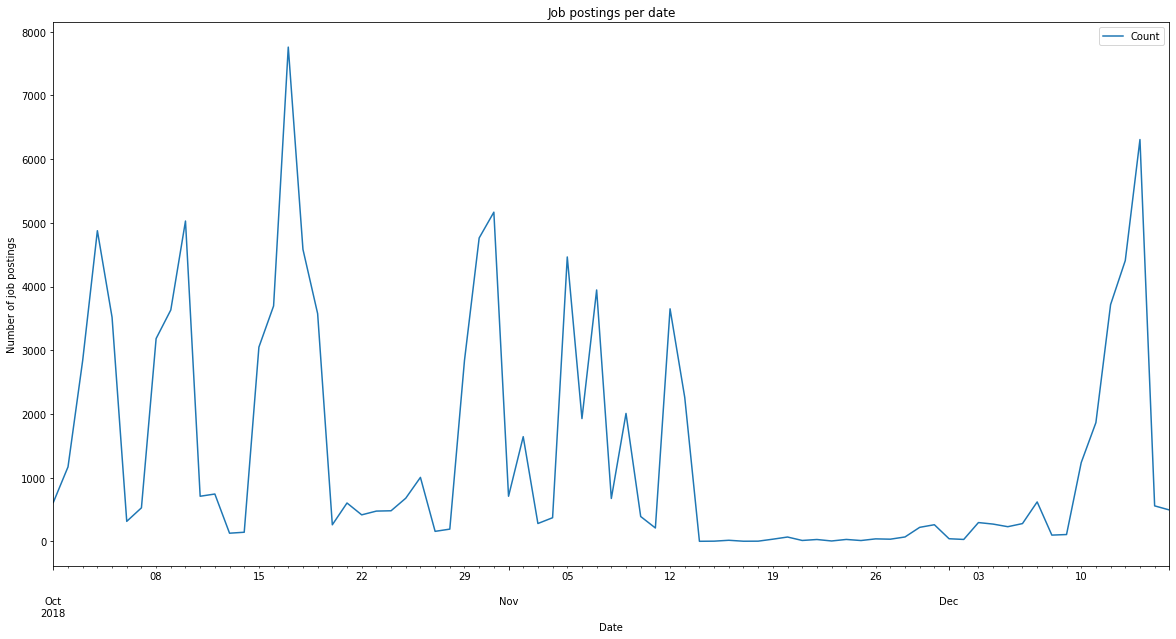

In [14]:
# Detecting pattern of posting
data6 = data[['Date']].copy()
data6 = data6.groupby(['Date']).size().reset_index().rename(columns={0:'Count'})
data6 = data6.sort_values(by=['Date'], ascending=True)

# Display total listings for each month
data6b = data6
data6b = data6b.groupby(data6b['Date'].dt.strftime('%B'))['Count'].sum().sort_values(ascending=False)

# Output may not be displayed to to large volume of data - top data sorted was used
print(data6b.head())

# Showcase top of data instead of all the other data
#print(data6)

data6.plot(x='Date',y='Count',kind='line',figsize=(20,10),ylabel='Number of job postings',xlabel='Date',title='Job postings per date')


    index                          Classification  Entries  Overall Market Share (%)
0      17  Information & Communication Technology    14713                 13.241952
1      15                   Hospitality & Tourism     8471                  7.624045
2      29                       Trades & Services     8450                  7.605144
3      20    Manufacturing, Transport & Logistics     7542                  6.787929
4      14                    Healthcare & Medical     7223                  6.500824
5       0                              Accounting     6595                  5.935613
6       1         Administration & Office Support     6000                  5.400103
7      10                    Education & Training     5385                  4.846592
8      25                                   Sales     4862                  4.375883
9       7                            Construction     4671                  4.203980
10     24              Retail & Consumer Products     4622       

<AxesSubplot:title={'center':'Job Sector market share'}, ylabel='Percentage of Market'>

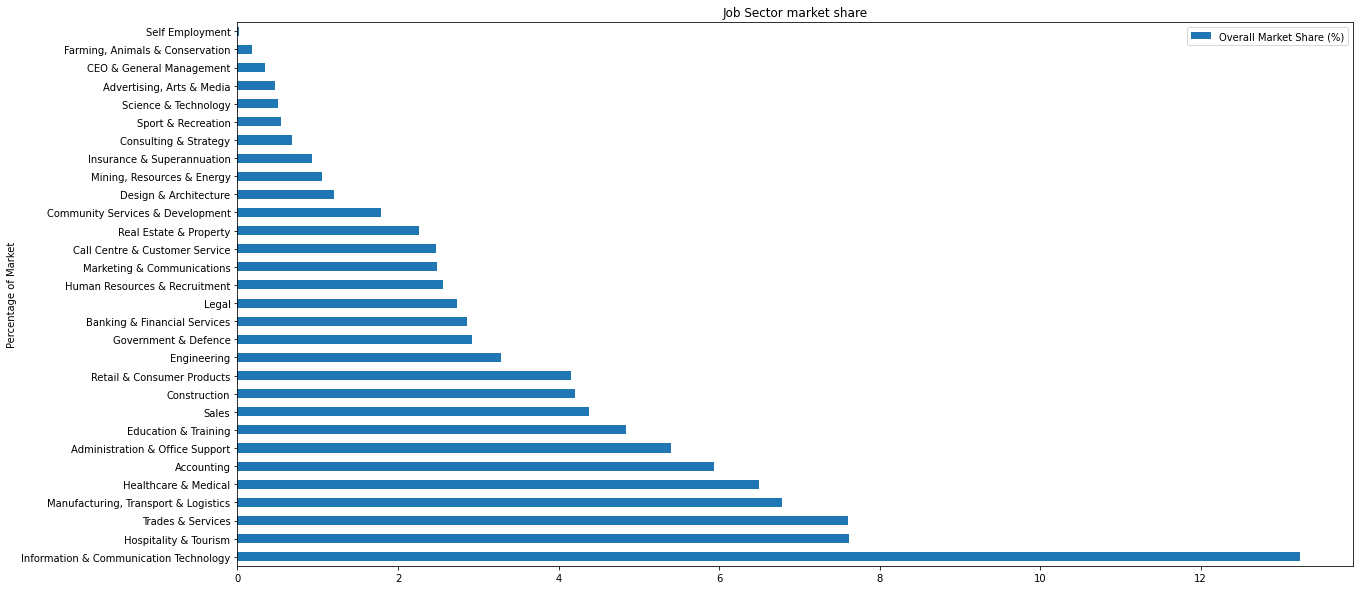

In [51]:
# Question 3: Studying the market by Sectors
# Check which sectors have the highest market share
data7 = data[['Classification']].copy()
data7 = data7.groupby(['Classification']).size().reset_index().rename(columns={0:'Entries'}).sort_values(by=['Entries'], ascending=False).reset_index() 

# Calculate the percentage of market share
data7['Overall Market Share (%)'] = data7['Entries']/data7['Entries'].sum()*100
print(data7.to_string())

data7.plot(x='Classification',y='Overall Market Share (%)',kind='barh' ,figsize=(20,10),ylabel='Classification',xlabel='Percentage of Market',title='Job Sector market share')


In [16]:
# In each Classification which Sub Classifications are the most popular
data8 = data[['Classification','SubClassification']].copy()
data8 = data8.groupby(['Classification','SubClassification']).size().reset_index().rename(columns={0:'Count'}).sort_values(by=['Count'], ascending=False).drop_duplicates(['Classification'])
print(data8.to_string())


                             Classification                          SubClassification  Count
234  Information & Communication Technology                     Developers/Programmers   2869
25          Administration & Office Support                  Administrative Assistants   2624
300    Manufacturing, Transport & Logistics        Warehousing, Storage & Distribution   2499
207                   Hospitality & Tourism                                Chefs/Cooks   2429
347              Retail & Consumer Products                          Retail Assistants   2170
354                                   Sales          Sales Representatives/Consultants   1838
166                    Government & Defence                         Government - State   1762
372                       Trades & Services                          Automotive Trades   1601
115                    Education & Training      Childcare & Outside School Hours Care   1531
69           Call Centre & Customer Service             Cust

c:\users\wt-pc\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[Text(0, 0.5, 'Salary')]

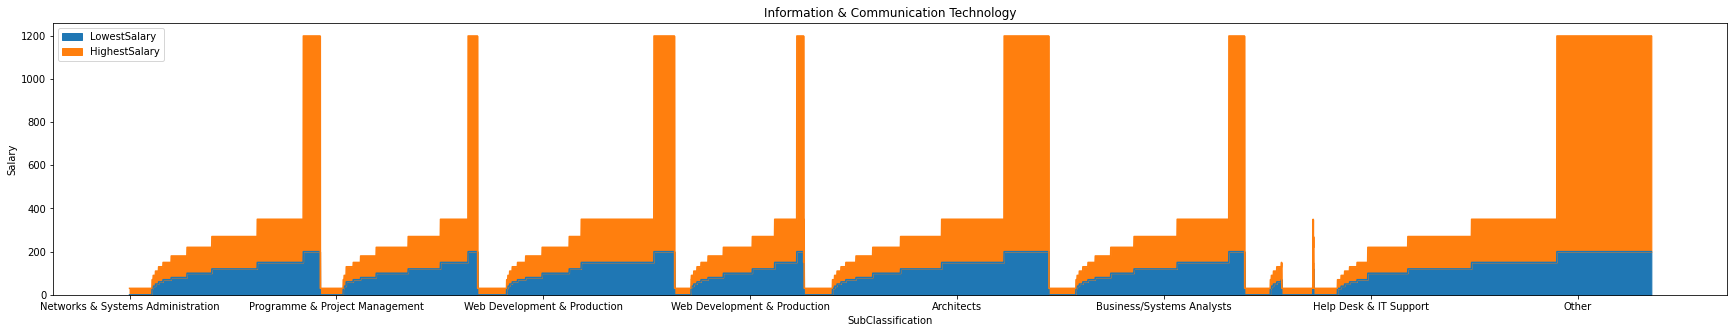

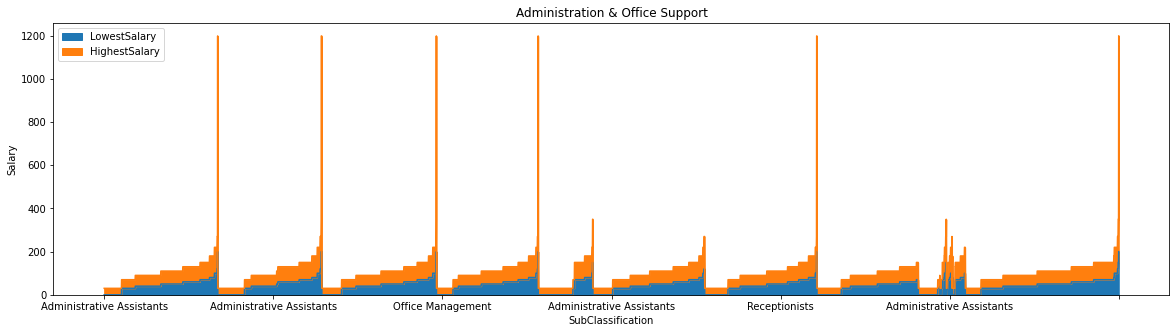

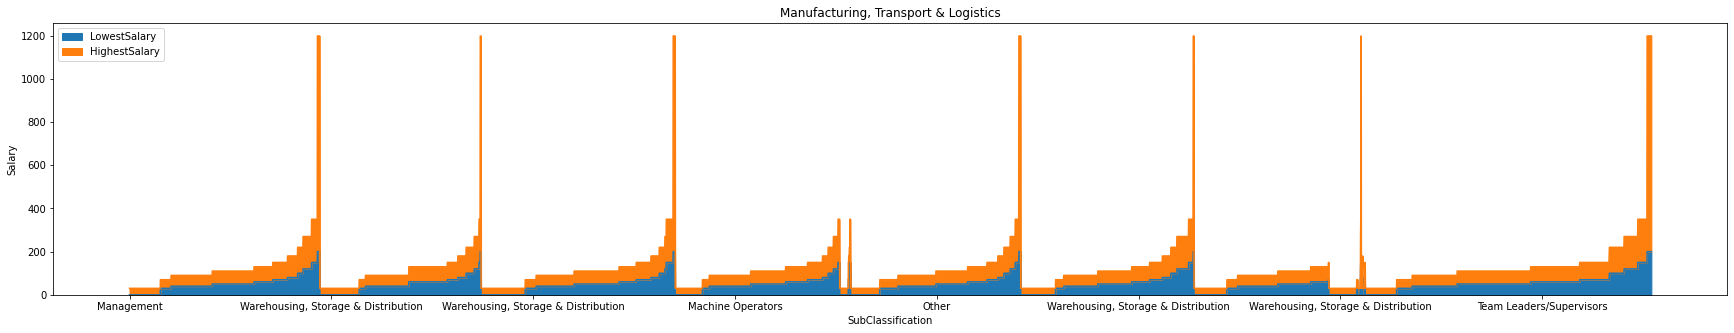

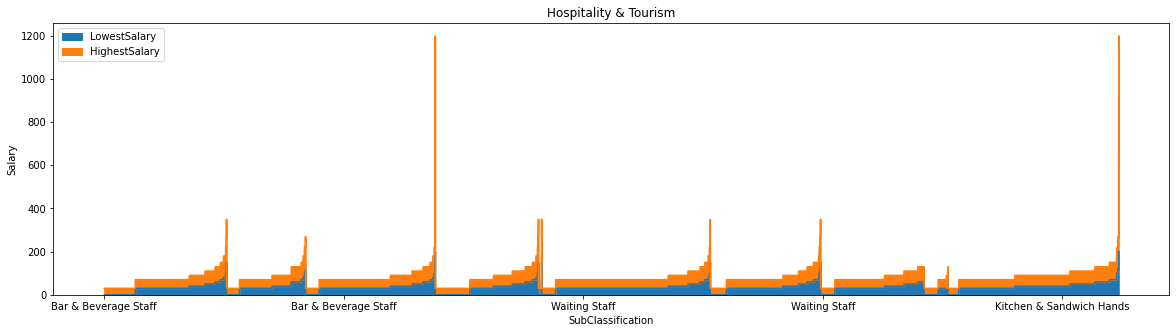

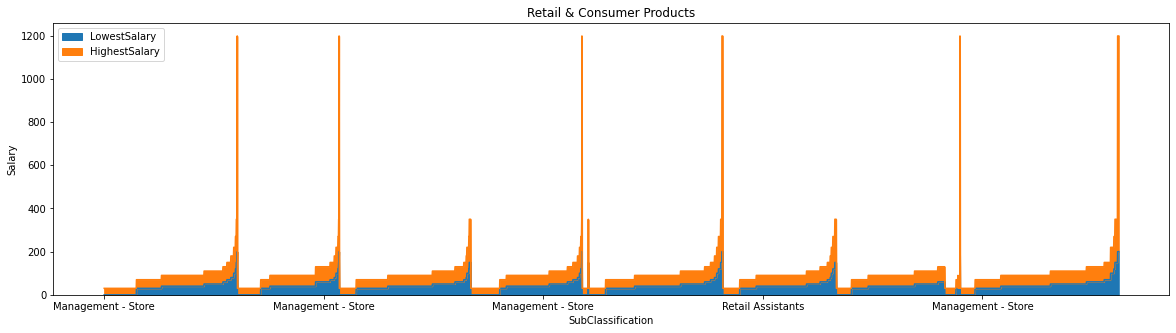

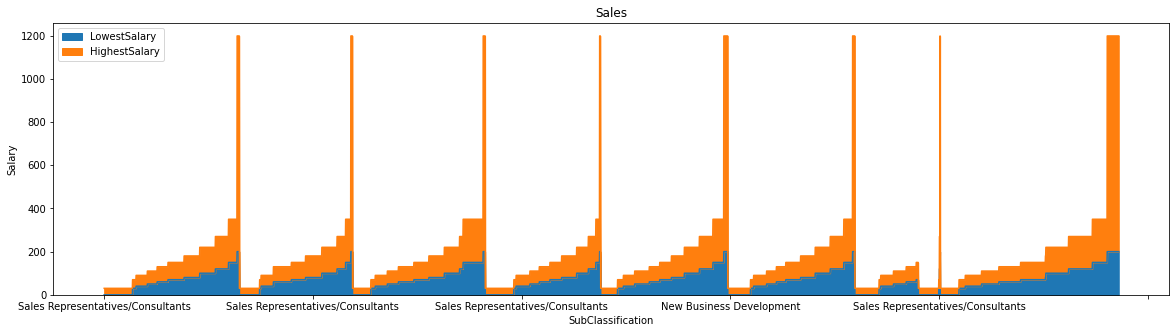

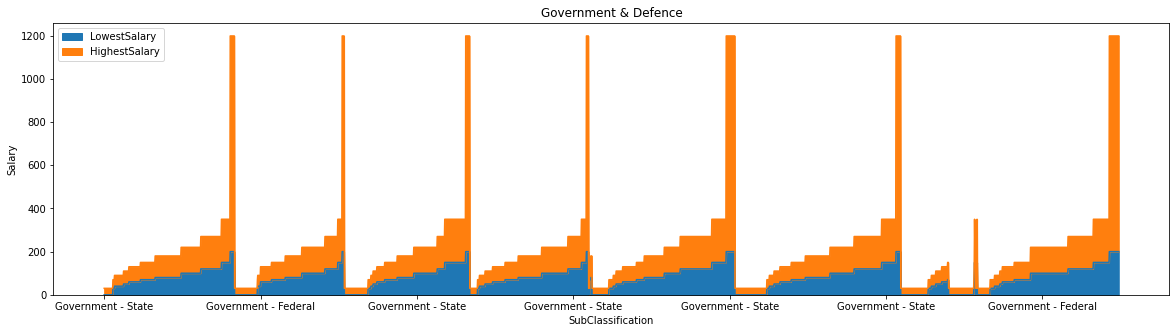

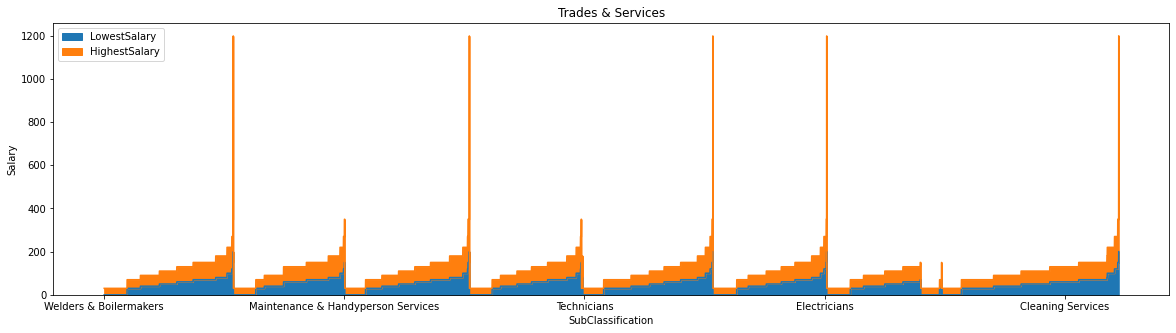

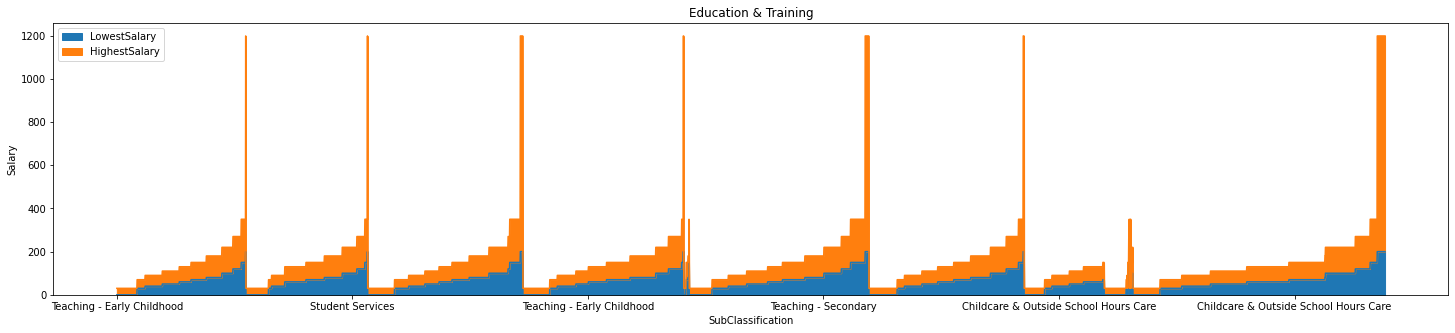

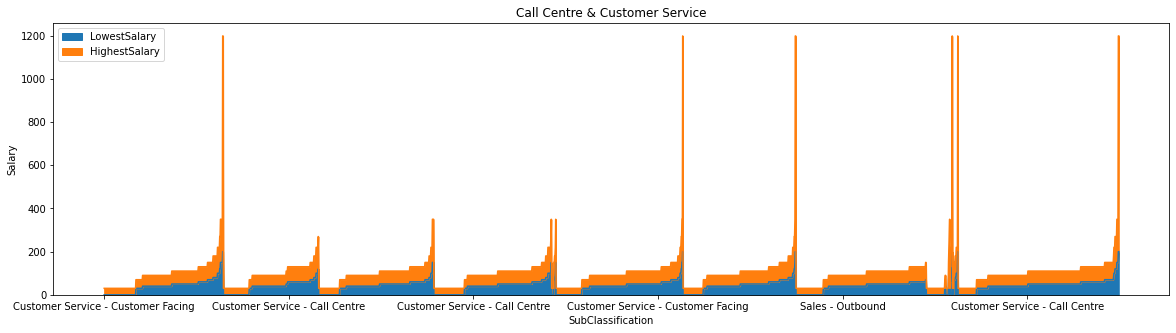

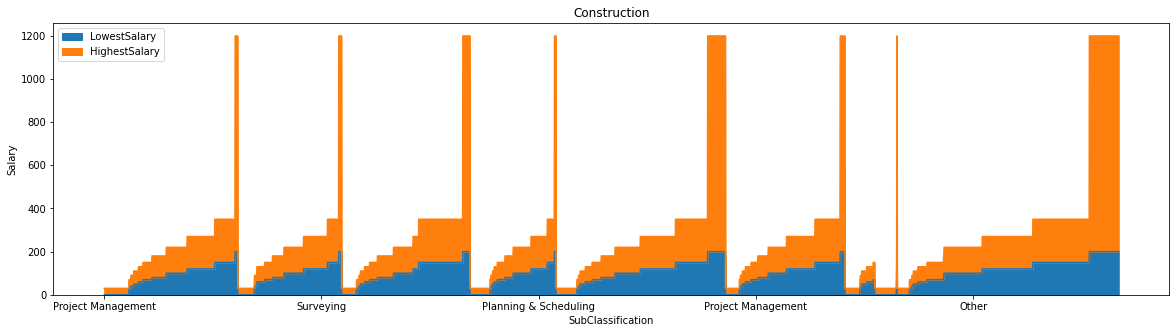

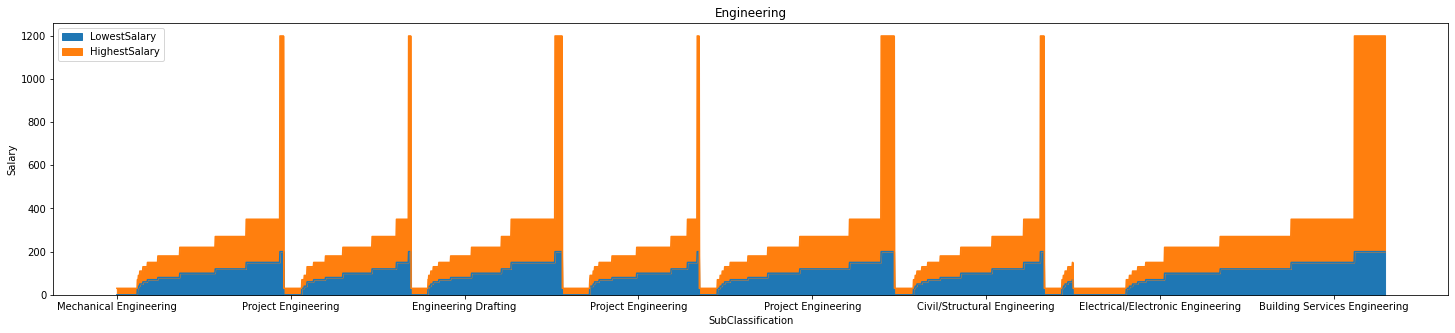

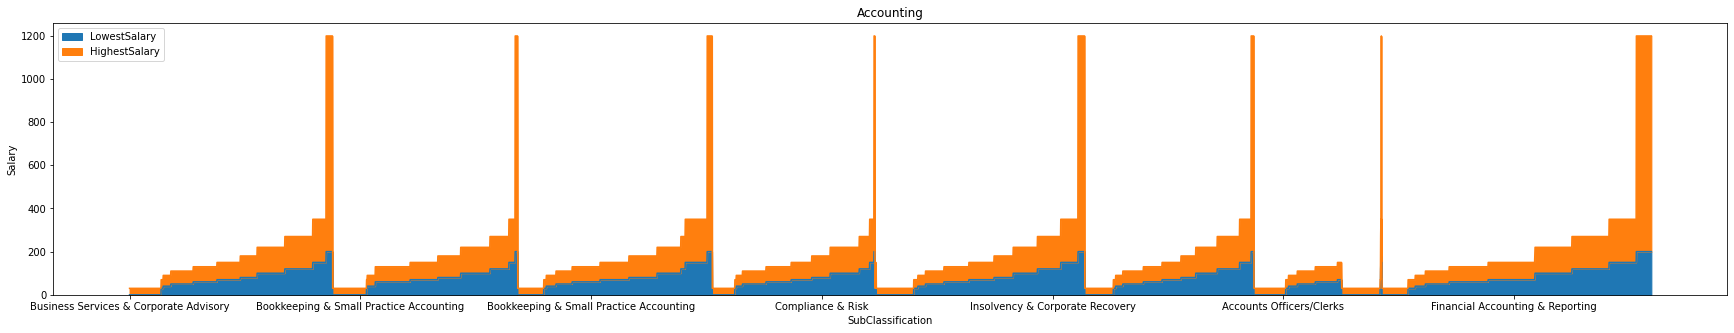

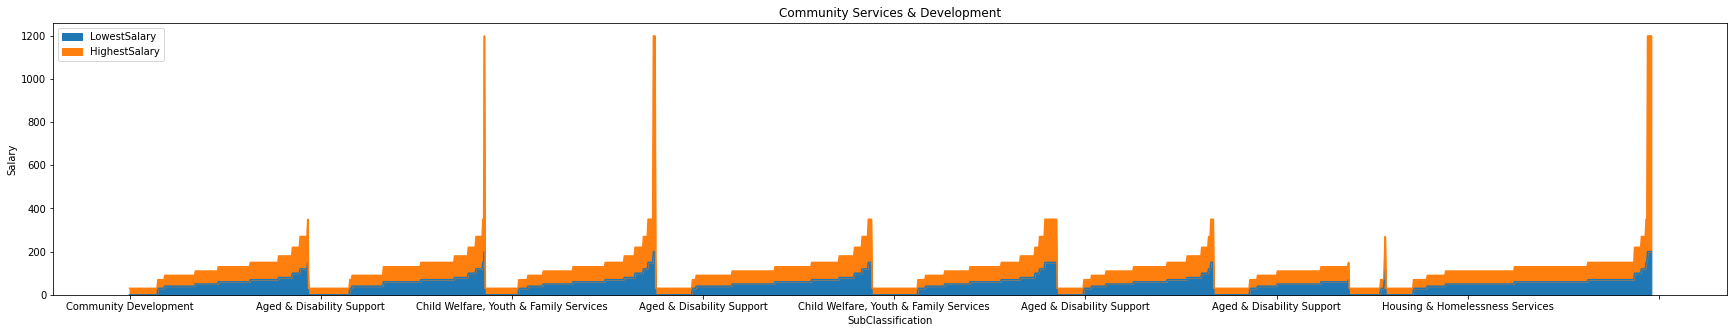

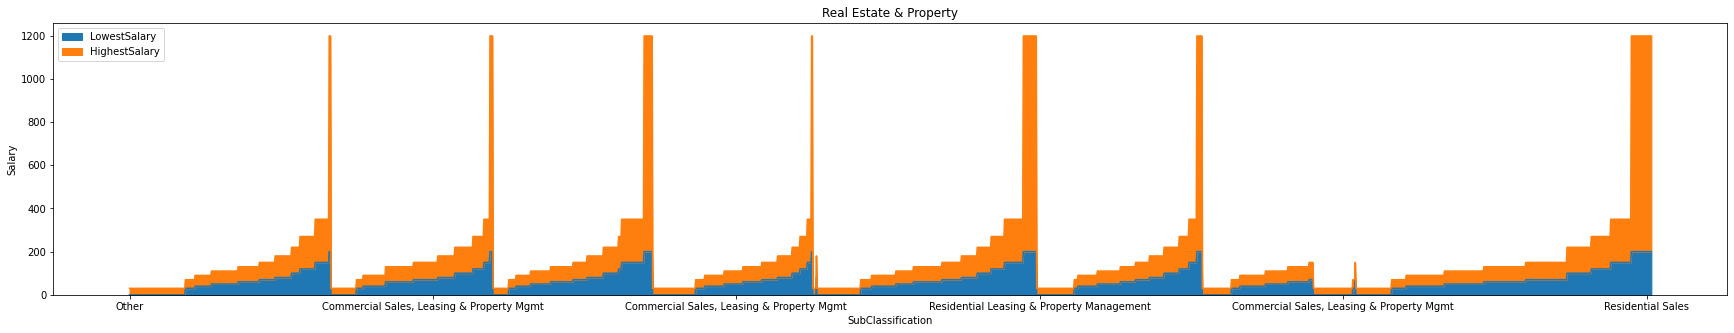

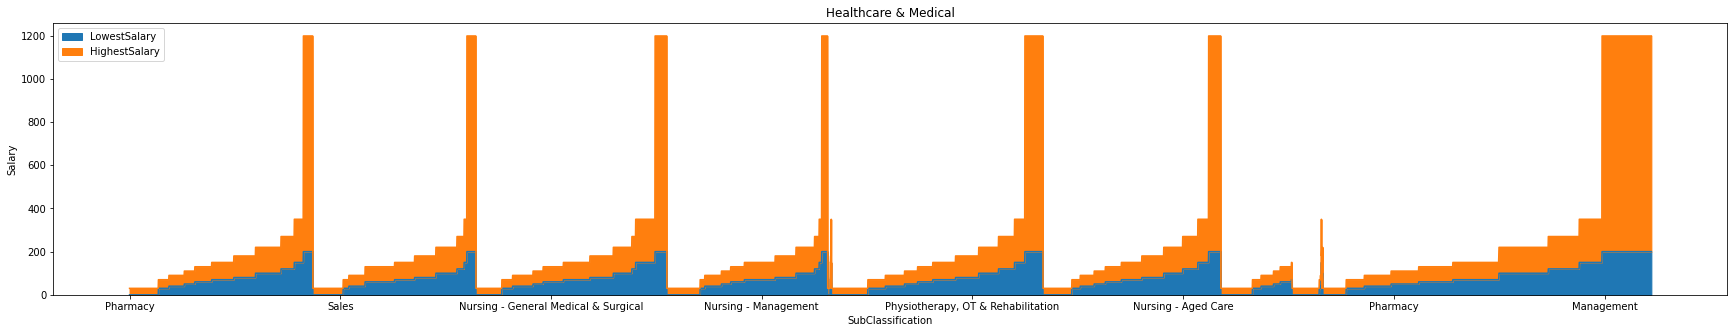

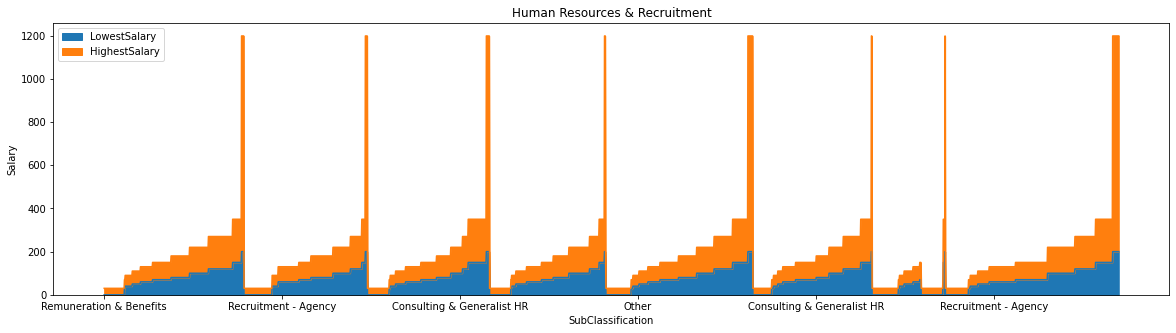

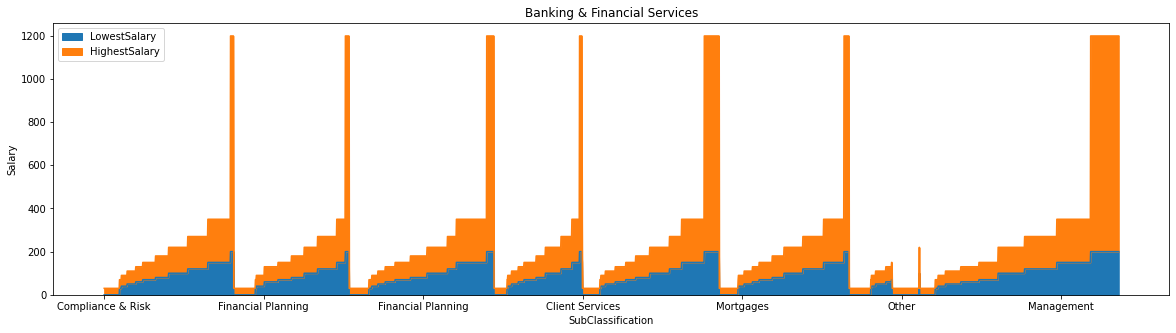

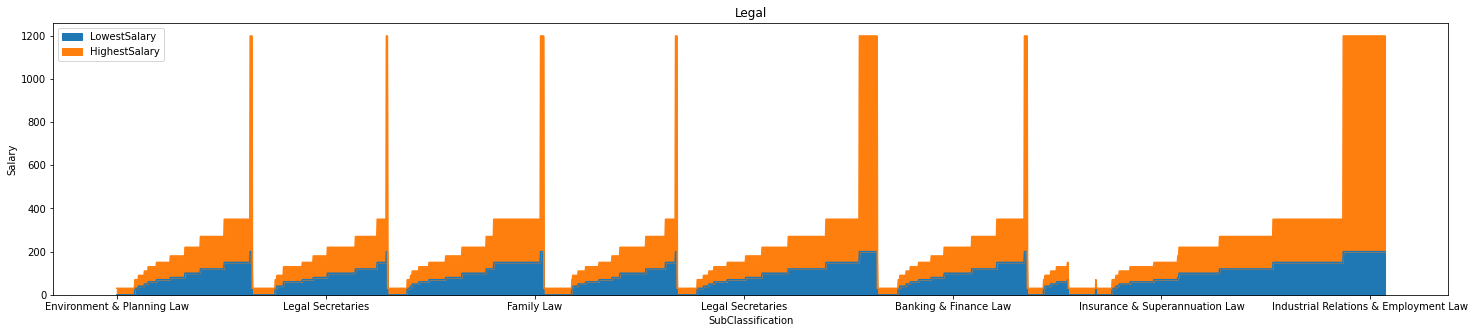

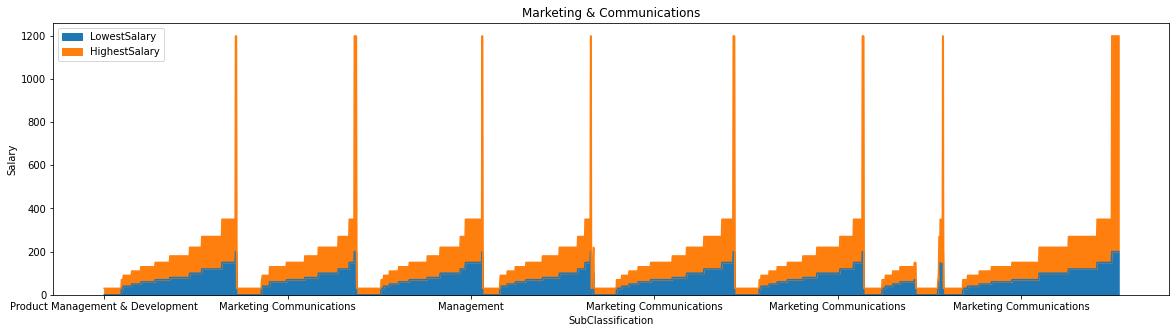

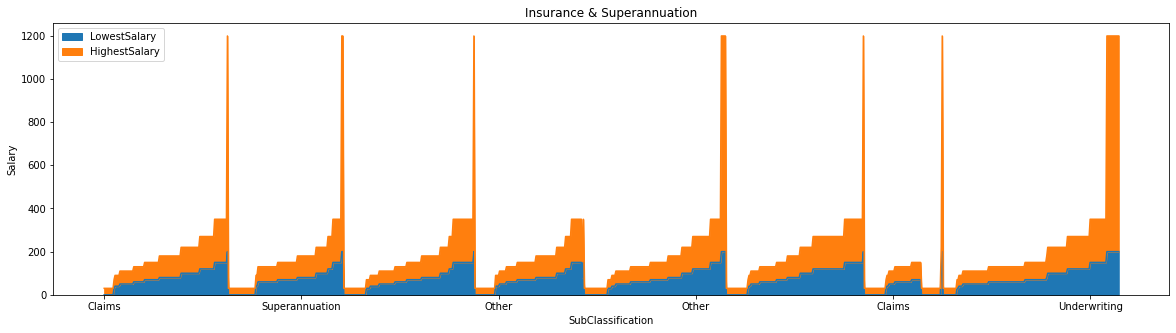

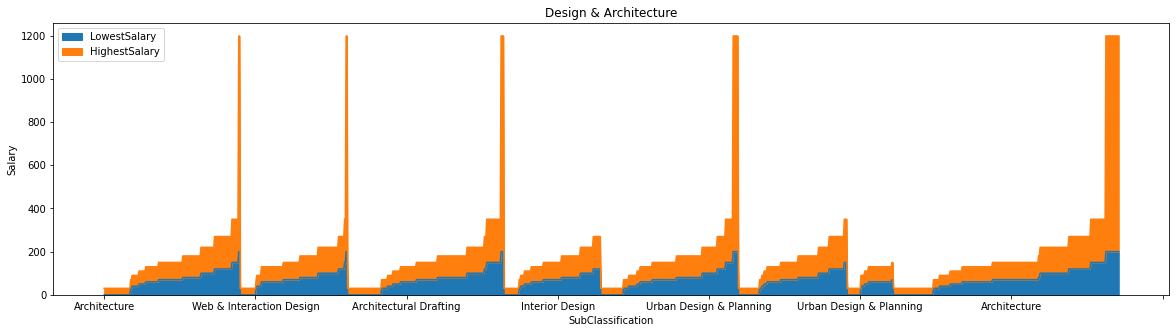

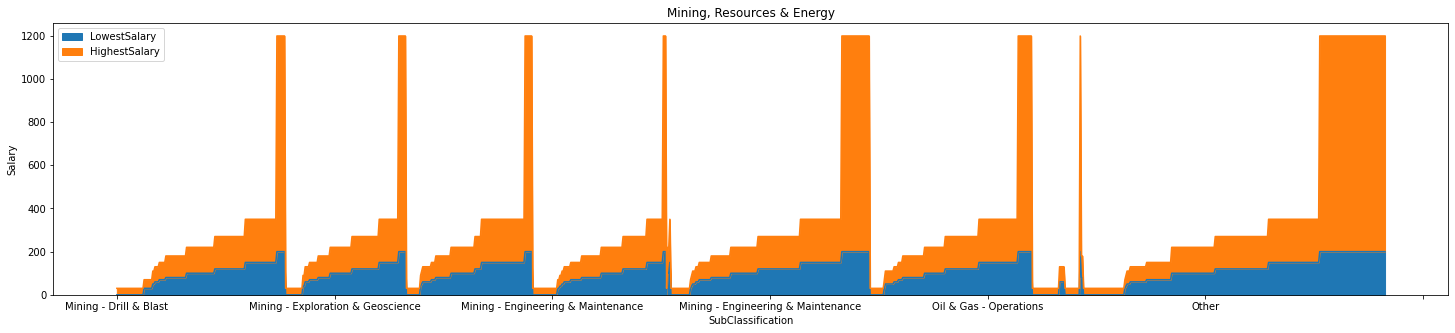

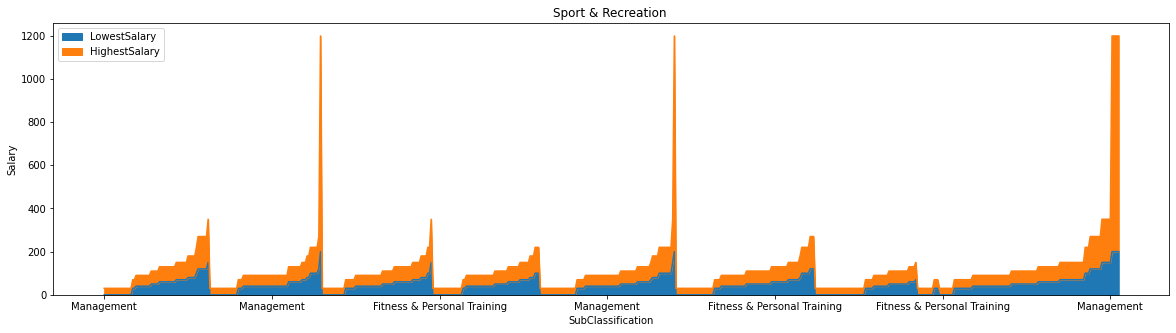

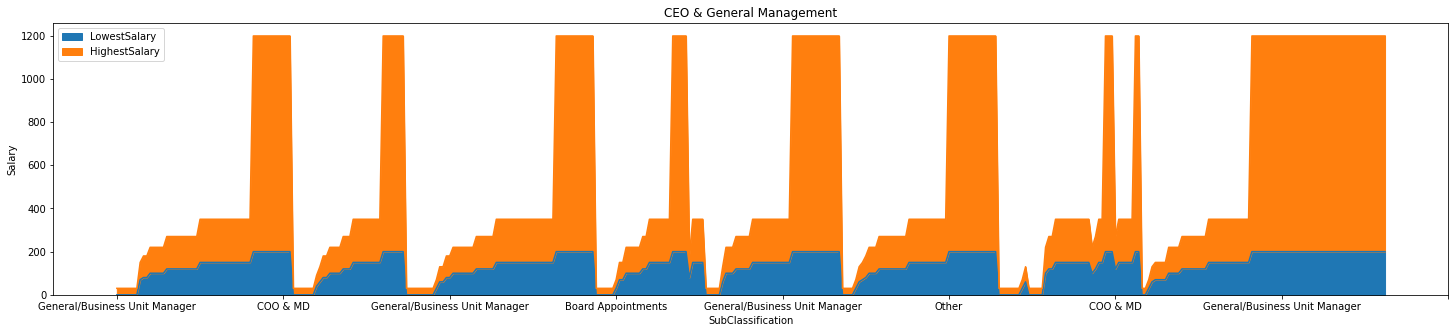

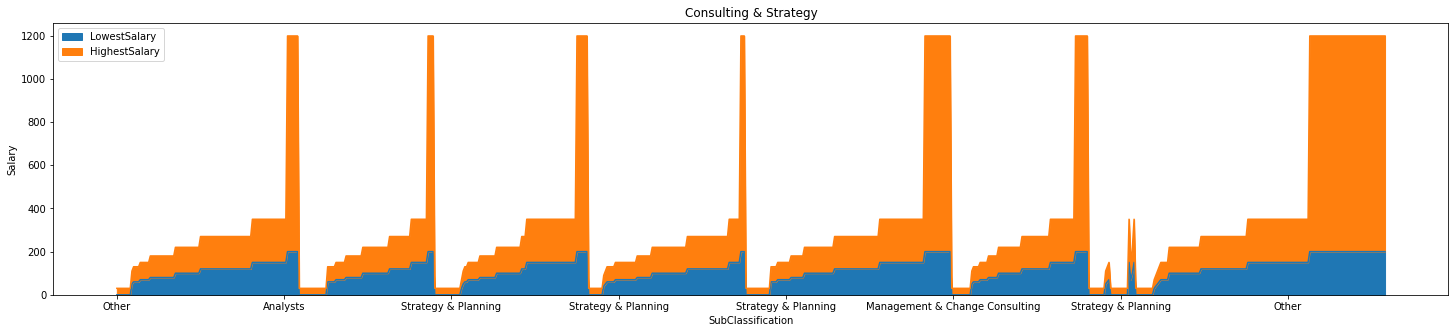

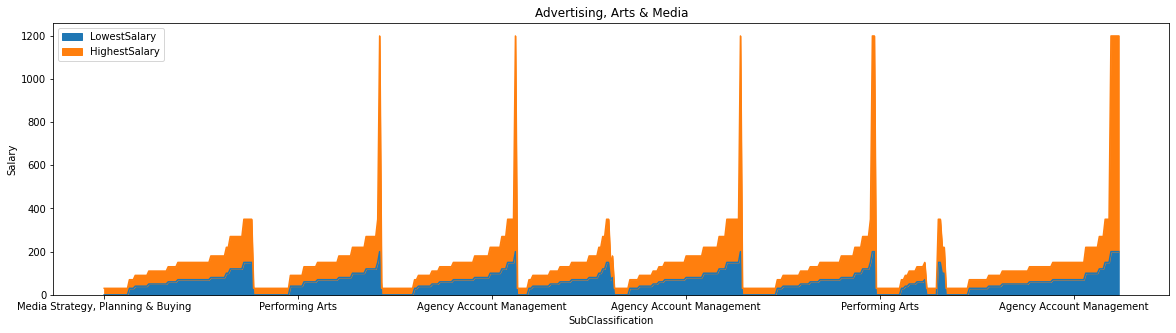

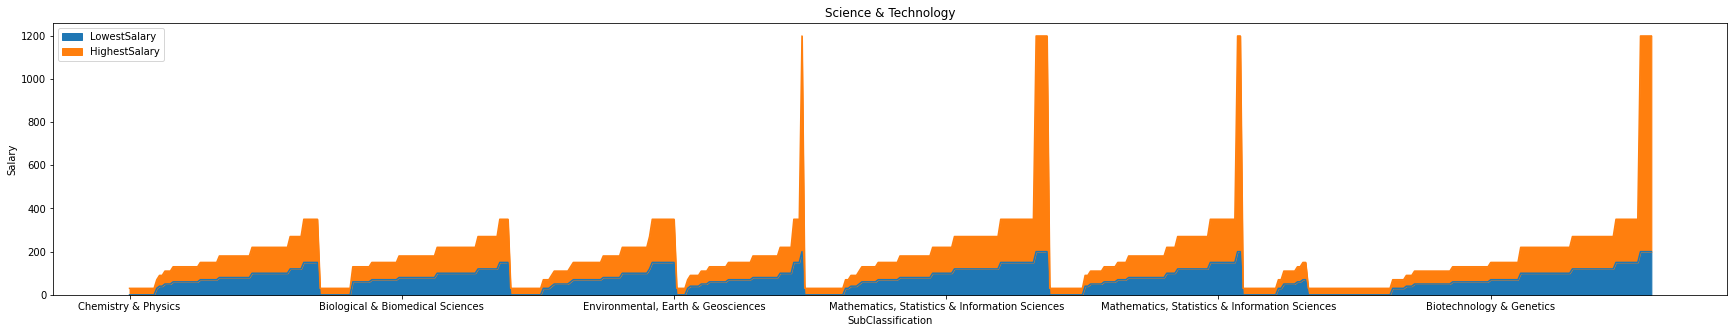

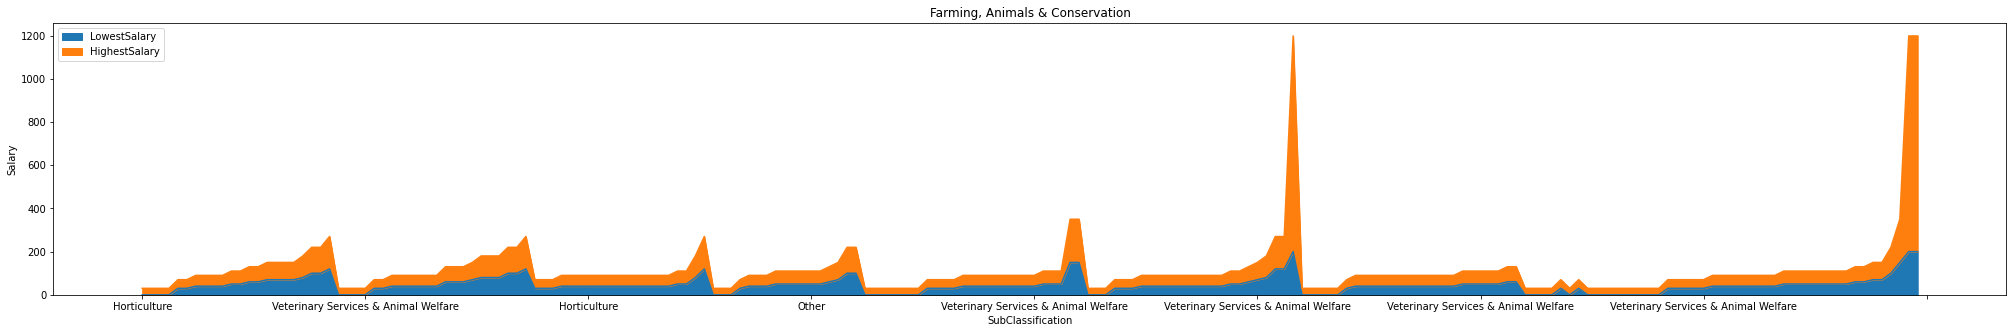

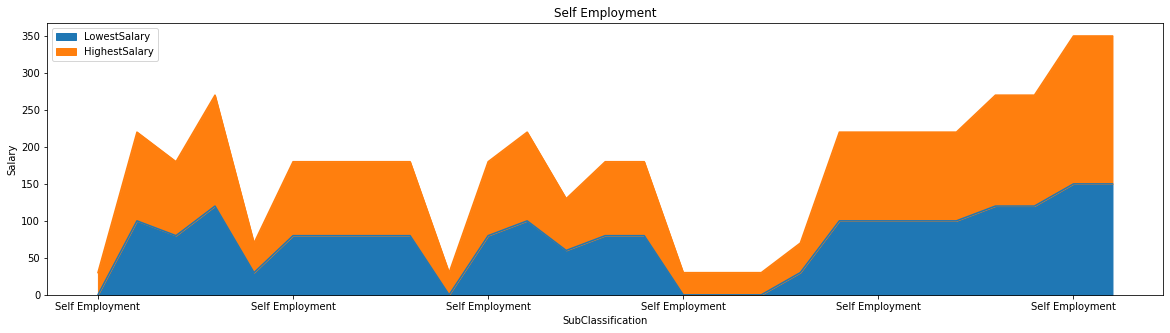

In [42]:
# Find the salary ranges for each Sub Classification within every Classification
data9 = data[['Classification', 'SubClassification','LowestSalary','HighestSalary']].copy()

# All of the following code is to produce graphs of every pay range for every sub classification in every classification
data91 = data9.loc[data9['Classification'] == 'Information & Communication Technology']
data91 = data91.drop(columns='Classification')
data91.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Information & Communication Technology').set(ylabel='Salary')

data92 = data9.loc[data9['Classification'] == 'Administration & Office Support']
data92 = data92.drop(columns='Classification')
data92.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Administration & Office Support').set(ylabel='Salary')

data93 = data9.loc[data9['Classification'] == 'Manufacturing, Transport & Logistics']
data93 = data93.drop(columns='Classification')
data93.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Manufacturing, Transport & Logistics').set(ylabel='Salary')

data94 = data9.loc[data9['Classification'] == 'Hospitality & Tourism']
data94 = data94.drop(columns='Classification')
data94.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Hospitality & Tourism').set(ylabel='Salary')

data95 = data9.loc[data9['Classification'] == 'Retail & Consumer Products']
data95 = data95.drop(columns='Classification')
data95.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Retail & Consumer Products').set(ylabel='Salary')

data96 = data9.loc[data9['Classification'] == 'Sales']
data96 = data96.drop(columns='Classification')
data96.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Sales').set(ylabel='Salary')

data97 = data9.loc[data9['Classification'] == 'Government & Defence']
data97 = data97.drop(columns='Classification')
data97.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Government & Defence').set(ylabel='Salary')

data98 = data9.loc[data9['Classification'] == 'Trades & Services']
data98 = data98.drop(columns='Classification')
data98.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Trades & Services').set(ylabel='Salary')

data99 = data9.loc[data9['Classification'] == 'Education & Training']
data99 = data99.drop(columns='Classification')
data99.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='Education & Training').set(ylabel='Salary')

data910 = data9.loc[data9['Classification'] == 'Call Centre & Customer Service']
data910 = data910.drop(columns='Classification')
data910.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Call Centre & Customer Service').set(ylabel='Salary')

data911 = data9.loc[data9['Classification'] == 'Construction']
data911 = data911.drop(columns='Classification')
data911.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Construction').set(ylabel='Salary')

data912 = data9.loc[data9['Classification'] == 'Engineering']
data912 = data912.drop(columns='Classification')
data912.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='Engineering').set(ylabel='Salary')

data913 = data9.loc[data9['Classification'] == 'Accounting']
data913 = data913.drop(columns='Classification')
data913.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Accounting').set(ylabel='Salary')

data914 = data9.loc[data9['Classification'] == 'Community Services & Development']
data914 = data914.drop(columns='Classification')
data914.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Community Services & Development').set(ylabel='Salary')

data915 = data9.loc[data9['Classification'] == 'Real Estate & Property']
data915 = data915.drop(columns='Classification')
data915.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Real Estate & Property').set(ylabel='Salary')

data916 = data9.loc[data9['Classification'] == 'Healthcare & Medical']
data916 = data916.drop(columns='Classification')
data916.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Healthcare & Medical').set(ylabel='Salary')

data917 = data9.loc[data9['Classification'] == 'Human Resources & Recruitment']
data917 = data917.drop(columns='Classification')
data917.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Human Resources & Recruitment').set(ylabel='Salary')

data918 = data9.loc[data9['Classification'] == 'Banking & Financial Services']
data918 = data918.drop(columns='Classification')
data918.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Banking & Financial Services').set(ylabel='Salary')

data919 = data9.loc[data9['Classification'] == 'Legal']
data919 = data919.drop(columns='Classification')
data919.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='Legal').set(ylabel='Salary')

data920 = data9.loc[data9['Classification'] == 'Marketing & Communications']
data920 = data920.drop(columns='Classification')
data920.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Marketing & Communications').set(ylabel='Salary')

data921 = data9.loc[data9['Classification'] == 'Insurance & Superannuation']
data921 = data921.drop(columns='Classification')
data921.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Insurance & Superannuation').set(ylabel='Salary')

data922 = data9.loc[data9['Classification'] == 'Design & Architecture']
data922 = data922.drop(columns='Classification')
data922.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Design & Architecture').set(ylabel='Salary')

data923 = data9.loc[data9['Classification'] == 'Mining, Resources & Energy']
data923 = data923.drop(columns='Classification')
data923.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='Mining, Resources & Energy').set(ylabel='Salary')

data924 = data9.loc[data9['Classification'] == 'Sport & Recreation']
data924 = data924.drop(columns='Classification')
data924.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Sport & Recreation ').set(ylabel='Salary')

data925 = data9.loc[data9['Classification'] == 'CEO & General Management']
data925 = data925.drop(columns='Classification')
data925.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='CEO & General Management').set(ylabel='Salary')

data926 = data9.loc[data9['Classification'] == 'Consulting & Strategy']
data926 = data926.drop(columns='Classification')
data926.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='Consulting & Strategy').set(ylabel='Salary')

data927 = data9.loc[data9['Classification'] == 'Advertising, Arts & Media']
data927 = data927.drop(columns='Classification')
data927.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Advertising, Arts & Media').set(ylabel='Salary')

data928 = data9.loc[data9['Classification'] == 'Science & Technology']
data928 = data928.drop(columns='Classification')
data928.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Science & Technology').set(ylabel='Salary')

data929 = data9.loc[data9['Classification'] == 'Farming, Animals & Conservation']
data929 = data929.drop(columns='Classification')
data929.set_index('SubClassification').plot(figsize=(35,5), kind='area',title='Farming, Animals & Conservation').set(ylabel='Salary')

data930 = data9.loc[data9['Classification'] == 'Self Employment']
data930 = data930.drop(columns='Classification')
data930.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Self Employment').set(ylabel='Salary')



In [ ]:
# Question 4: Visualize the data
